In [1]:
import numpy as np
from matplotlib import animation
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
from IPython.display import HTML
sns.set()

In [2]:
def get_vocab(file, lower = False):
    with open(file, 'r') as fopen:
        data = fopen.read()
    if lower:
        data = data.lower()
    vocab = list(set(data))
    return data, vocab

def embed_to_onehot(data, vocab):
    onehot = np.zeros((len(data), len(vocab)), dtype = np.float32)
    for i in range(len(data)):
        onehot[i, vocab.index(data[i])] = 1.0
    return onehot

In [3]:
text, text_vocab = get_vocab('consumer.h', lower = False)
onehot = embed_to_onehot(text, text_vocab)

In [4]:
learning_rate = 0.01
batch_size = 128
sequence_length = 64
num_layers = 2
size_layer = 512
possible_batch_id = range(len(text) - sequence_length - 1)
random_starter = np.random.randint(0, len(text) - sequence_length - 1)
tag = text[random_starter-1:(random_starter-1)+sequence_length]
onehot_tag = np.argmax(onehot[random_starter-1:(random_starter-1)+sequence_length,:],axis=1)

In [5]:
class Model_LSTM:
    def __init__(self, num_layers, size_layer, dimension, learning_rate):
        def lstm_cell():
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
        self.rnn_cells = tf.nn.rnn_cell.MultiRNNCell([lstm_cell() for _ in range(num_layers)], 
                                                     state_is_tuple = False)
        self.X = tf.placeholder(tf.float32, (None, None, dimension))
        self.Y = tf.placeholder(tf.float32, (None, None, dimension))
        self.hidden_layer = tf.placeholder(tf.float32, (None, num_layers * 2 * size_layer))
        self.outputs, self.last_state = tf.nn.dynamic_rnn(self.rnn_cells, self.X, 
                                                          initial_state = self.hidden_layer, 
                                                          dtype = tf.float32)
        rnn_W = tf.Variable(tf.random_normal((size_layer, dimension)))
        rnn_B = tf.Variable(tf.random_normal([dimension]))
        self.logits = tf.matmul(tf.reshape(self.outputs, [-1, size_layer]), rnn_W) + rnn_B
        y_batch_long = tf.reshape(self.Y, [-1, dimension])
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, 
                                                                           labels = y_batch_long))
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate, 0.9).minimize(self.cost)
        self.correct_pred = tf.equal(tf.argmax(self.logits, 1), tf.argmax(y_batch_long, 1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
        seq_shape = tf.shape(self.outputs)
        self.final_outputs = tf.reshape(tf.nn.softmax(self.logits), 
                                        (seq_shape[0], seq_shape[1], 
                                         dimension))

In [6]:
class Model_GRU:
    def __init__(self, num_layers, size_layer, dimension, learning_rate):
        def lstm_cell():
            return tf.nn.rnn_cell.GRUCell(size_layer)
        self.rnn_cells = tf.nn.rnn_cell.MultiRNNCell([lstm_cell() for _ in range(num_layers)], 
                                                     state_is_tuple = False)
        self.X = tf.placeholder(tf.float32, (None, None, dimension))
        self.Y = tf.placeholder(tf.float32, (None, None, dimension))
        self.hidden_layer = tf.placeholder(tf.float32, (None, num_layers * size_layer))
        self.outputs, self.last_state = tf.nn.dynamic_rnn(self.rnn_cells, self.X, 
                                                          initial_state = self.hidden_layer, 
                                                          dtype = tf.float32)
        rnn_W = tf.Variable(tf.random_normal((size_layer, dimension)))
        rnn_B = tf.Variable(tf.random_normal([dimension]))
        self.logits = tf.matmul(tf.reshape(self.outputs, [-1, size_layer]), rnn_W) + rnn_B
        y_batch_long = tf.reshape(self.Y, [-1, dimension])
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, 
                                                                           labels = y_batch_long))
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate, 0.9).minimize(self.cost)
        self.correct_pred = tf.equal(tf.argmax(self.logits, 1), tf.argmax(y_batch_long, 1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
        seq_shape = tf.shape(self.outputs)
        self.final_outputs = tf.reshape(tf.nn.softmax(self.logits), 
                                        (seq_shape[0], seq_shape[1], 
                                         dimension))

In [7]:
class Model_LSTM_Bi:
    def __init__(self, num_layers, size_layer, dimension, learning_rate):
        def lstm_cell():
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
        self.rnn_cells_f = tf.nn.rnn_cell.MultiRNNCell([lstm_cell() for _ in range(num_layers)], 
                                                     state_is_tuple = False)
        self.rnn_cells_b = tf.nn.rnn_cell.MultiRNNCell([lstm_cell() for _ in range(num_layers)], 
                                                     state_is_tuple = False)
        self.X = tf.placeholder(tf.float32, (None, None, dimension))
        self.Y = tf.placeholder(tf.float32, (None, None, dimension))
        self.hidden_layer_f = tf.placeholder(tf.float32, (None, num_layers * 2 * size_layer))
        self.hidden_layer_b = tf.placeholder(tf.float32, (None, num_layers * 2 * size_layer))
        self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
            self.rnn_cells_f, 
            self.rnn_cells_b,
            self.X, 
            initial_state_fw = self.hidden_layer_f,
            initial_state_bw = self.hidden_layer_b,
            dtype = tf.float32)
        self.outputs = tf.concat(self.outputs, 2)
        rnn_W = tf.Variable(tf.random_normal((size_layer * 2, dimension)))
        rnn_B = tf.Variable(tf.random_normal([dimension]))
        self.logits = tf.matmul(tf.reshape(self.outputs, [-1, size_layer * 2]), rnn_W) + rnn_B
        y_batch_long = tf.reshape(self.Y, [-1, dimension])
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, 
                                                                           labels = y_batch_long))
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate, 0.9).minimize(self.cost)
        self.correct_pred = tf.equal(tf.argmax(self.logits, 1), tf.argmax(y_batch_long, 1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
        seq_shape = tf.shape(self.outputs)
        self.final_outputs = tf.reshape(tf.nn.softmax(self.logits), 
                                        (seq_shape[0], seq_shape[1], 
                                         dimension))

In [8]:
class Model_GRU_Bi:
    def __init__(self, num_layers, size_layer, dimension, learning_rate):
        def lstm_cell():
            return tf.nn.rnn_cell.GRUCell(size_layer)
        self.rnn_cells_f = tf.nn.rnn_cell.MultiRNNCell([lstm_cell() for _ in range(num_layers)],
                                                      state_is_tuple = False)
        self.rnn_cells_b = tf.nn.rnn_cell.MultiRNNCell([lstm_cell() for _ in range(num_layers)],
                                                      state_is_tuple = False)
        self.X = tf.placeholder(tf.float32, (None, None, dimension))
        self.Y = tf.placeholder(tf.float32, (None, None, dimension))
        self.hidden_layer_f = tf.placeholder(tf.float32, (None, num_layers * size_layer))
        self.hidden_layer_b = tf.placeholder(tf.float32, (None, num_layers * size_layer))
        self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
            self.rnn_cells_f, 
            self.rnn_cells_b,
            self.X, 
            initial_state_fw = self.hidden_layer_f,
            initial_state_bw = self.hidden_layer_b,
            dtype = tf.float32)
        self.outputs = tf.concat(self.outputs, 2)
        rnn_W = tf.Variable(tf.random_normal((size_layer * 2, dimension)))
        rnn_B = tf.Variable(tf.random_normal([dimension]))
        self.logits = tf.matmul(tf.reshape(self.outputs, [-1, size_layer * 2]), rnn_W) + rnn_B
        y_batch_long = tf.reshape(self.Y, [-1, dimension])
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, 
                                                                           labels = y_batch_long))
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate, 0.9).minimize(self.cost)
        self.correct_pred = tf.equal(tf.argmax(self.logits, 1), tf.argmax(y_batch_long, 1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
        seq_shape = tf.shape(self.outputs)
        self.final_outputs = tf.reshape(tf.nn.softmax(self.logits), 
                                        (seq_shape[0], seq_shape[1], 
                                         dimension))

In [9]:
def train_random_sequence(sess, model, init_value):
    batch_x = np.zeros((batch_size, sequence_length, len(text_vocab)))
    batch_y = np.zeros((batch_size, sequence_length, len(text_vocab)))
    batch_id = random.sample(possible_batch_id, batch_size)
    for n in range(sequence_length):
        id1 = [k + n for k in batch_id]
        id2 = [k + n + 1 for k in batch_id]
        batch_x[:,n,:] = onehot[id1, :]
        batch_y[:,n,:] = onehot[id2, :]
    last_state, _, loss = sess.run([model.last_state, model.optimizer, model.cost], 
                                       feed_dict = {model.X: batch_x, 
                                                    model.Y: batch_y,
                                                    model.hidden_layer: init_value})
    accuracy = sess.run(model.accuracy, feed_dict = {model.X: batch_x, 
                                                     model.Y: batch_y, 
                                                     model.hidden_layer: init_value})
    return last_state, loss, accuracy

In [10]:
def train_random_sequence_bi(sess, model, init_value_fw, init_value_bw):
    batch_x = np.zeros((batch_size, sequence_length, len(text_vocab)))
    batch_y = np.zeros((batch_size, sequence_length, len(text_vocab)))
    batch_id = random.sample(possible_batch_id, batch_size)
    for n in range(sequence_length):
        id1 = [k + n for k in batch_id]
        id2 = [k + n + 1 for k in batch_id]
        batch_x[:,n,:] = onehot[id1, :]
        batch_y[:,n,:] = onehot[id2, :]
    last_state, _, loss = sess.run([model.last_state, model.optimizer, model.cost], 
                                       feed_dict = {model.X: batch_x, 
                                                    model.Y: batch_y,
                                                    model.hidden_layer_f: init_value_fw,
                                                    model.hidden_layer_b: init_value_bw})
    accuracy = sess.run(model.accuracy, feed_dict = {model.X: batch_x, 
                                                     model.Y: batch_y, 
                                                     model.hidden_layer_f: init_value_fw,
                                                     model.hidden_layer_b: init_value_bw})
    return last_state[0], last_state[1], loss, accuracy

In [11]:
def generate_based_sequence(sess, model, tag, gru=False):
    onehot = embed_to_onehot(tag, text_vocab)
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    if gru:
        init_value = np.zeros((1, num_layers * size_layer))
    batch_x = np.zeros((1, sequence_length, len(text_vocab)))
    batch_x[0, :, :] = onehot
    prob = sess.run(model.final_outputs, 
                    feed_dict = {model.X: batch_x, model.hidden_layer: init_value})
    results = []
    for i in range(prob.shape[1]):
        results.append(np.random.choice(range(len(text_vocab)), p = prob[0,i,:]))
    return results

In [12]:
def generate_based_sequence_bi(sess, model, tag, gru=False):
    onehot = embed_to_onehot(tag, text_vocab)
    init_value_fw = np.zeros((1, num_layers * 2 * size_layer))
    init_value_bw = np.zeros((1, num_layers * 2 * size_layer))
    if gru:
        init_value_fw = np.zeros((1, num_layers * size_layer))
        init_value_bw = np.zeros((1, num_layers * size_layer))
    batch_x = np.zeros((1, sequence_length, len(text_vocab)))
    batch_x[0, :, :] = onehot
    prob = sess.run(model.final_outputs, 
                    feed_dict = {model.X: batch_x, model.hidden_layer_f: init_value_fw,
                                model.hidden_layer_b: init_value_bw})
    results = []
    for i in range(prob.shape[1]):
        results.append(np.random.choice(range(len(text_vocab)), p = prob[0,i,:]))
    return results

In [13]:
tf.reset_default_graph()
first_graph = tf.Graph()
with first_graph.as_default():
    lstm = Model_LSTM(num_layers, size_layer, len(text_vocab), learning_rate)
    first_sess = tf.InteractiveSession()
    first_sess.run(tf.global_variables_initializer())
    
second_graph = tf.Graph()
with second_graph.as_default():
    gru = Model_GRU(num_layers, size_layer, len(text_vocab), learning_rate)
    second_sess = tf.InteractiveSession()
    second_sess.run(tf.global_variables_initializer())
    
third_graph = tf.Graph()
with third_graph.as_default():
    lstm_bi = Model_LSTM_Bi(num_layers, size_layer, len(text_vocab), learning_rate)
    third_sess = tf.InteractiveSession()
    third_sess.run(tf.global_variables_initializer())
    
fourth_graph = tf.Graph()
with fourth_graph.as_default():
    gru_bi = Model_GRU_Bi(num_layers, size_layer, len(text_vocab), learning_rate)
    fourth_sess = tf.InteractiveSession()
    fourth_sess.run(tf.global_variables_initializer())

In [14]:
init_value_lstm = np.zeros((batch_size, num_layers* 2*size_layer))
init_value_gru = np.zeros((batch_size, num_layers*size_layer))
init_value_lstm_f = np.zeros((batch_size, num_layers* 2*size_layer))
init_value_lstm_b = np.zeros((batch_size, num_layers* 2*size_layer))
init_value_gru_f = np.zeros((batch_size, num_layers*size_layer))
init_value_gru_b = np.zeros((batch_size, num_layers*size_layer))

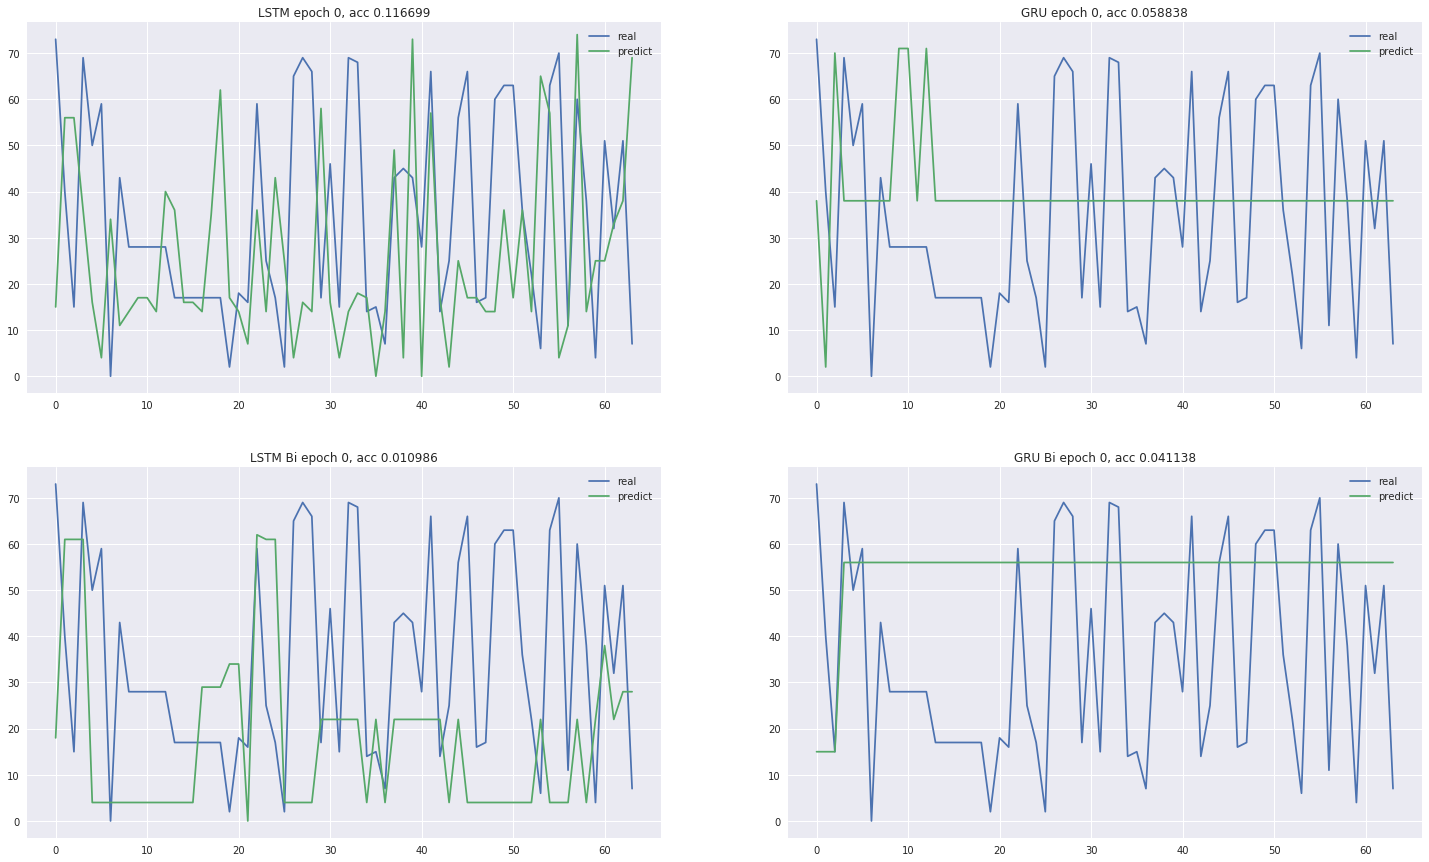

In [15]:
fig = plt.figure(figsize=(25,15))
x_axis = np.arange(sequence_length)
lines= []
plt.subplot(2, 2, 1)
seq=generate_based_sequence(first_sess, lstm, tag)
plt.plot(onehot_tag, label='real')
lines.append(plt.plot([],[], label='predict'))
plt.legend()
plt.title('LSTM epoch %d, acc %f'%(0, 0))
plt.subplot(2, 2, 2)
seq=generate_based_sequence(second_sess, gru, tag, True)
plt.plot(onehot_tag, label='real')
lines.append(plt.plot([],[], label='predict'))
plt.legend()
plt.title('GRU epoch %d, acc %f'%(0, 0))
plt.subplot(2, 2, 3)
seq=generate_based_sequence_bi(third_sess, lstm_bi, tag)
plt.plot(onehot_tag, label='real')
lines.append(plt.plot([], label='predict'))
plt.legend()
plt.title('LSTM Bi epoch %d, acc %f'%(0, 0))
plt.subplot(2, 2, 4)
seq=generate_based_sequence_bi(fourth_sess, gru_bi, tag,True)
plt.plot(onehot_tag, label='real')
lines.append(plt.plot([], label='predict'))
plt.title('GRU Bi epoch %d, acc %f'%(0, 0))
plt.legend()

def training(epoch):
    global init_value_lstm, init_value_gru, init_value_lstm_f
    global init_value_lstm_b, init_value_gru_f, init_value_gru_b
    init_value_lstm, _, acc = train_random_sequence(first_sess, lstm, init_value_lstm)
    plt.subplot(2, 2, 1)
    seq=generate_based_sequence(first_sess, lstm, tag)
    plt.title('LSTM epoch %d, acc %f'%(epoch, acc))
    lines[0][0].set_data(x_axis, seq)
    init_value_gru, _, acc = train_random_sequence(second_sess, gru, init_value_gru)
    plt.subplot(2, 2, 2)
    seq=generate_based_sequence(second_sess, gru, tag,True)
    plt.title('GRU epoch %d, acc %f'%(epoch, acc))
    lines[1][0].set_data(x_axis, seq)
    init_value_lstm_f, init_value_lstm_b, _, acc = train_random_sequence_bi(third_sess, lstm_bi, init_value_lstm_f, init_value_lstm_b)
    plt.subplot(2, 2, 3)
    seq=generate_based_sequence_bi(third_sess, lstm_bi, tag)
    plt.title('LSTM Bi epoch %d, acc %f'%(epoch, acc))
    lines[2][0].set_data(x_axis, seq)
    init_value_gru_f, init_value_gru_b, _, acc = train_random_sequence_bi(fourth_sess, gru_bi, init_value_gru_f, init_value_gru_b)
    plt.subplot(2, 2, 4)
    seq=generate_based_sequence_bi(fourth_sess, gru_bi, tag, True)
    plt.title('GRU Bi epoch %d, acc %f'%(epoch, acc))
    lines[3][0].set_data(x_axis, seq)
    return lines, plt

anim = animation.FuncAnimation(fig, training, frames=100, interval=200)
anim.save('animation-comparison.gif', writer='imagemagick', fps=10)